Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.7/donuts_dark_gk/gk_donut_José_Sá.png


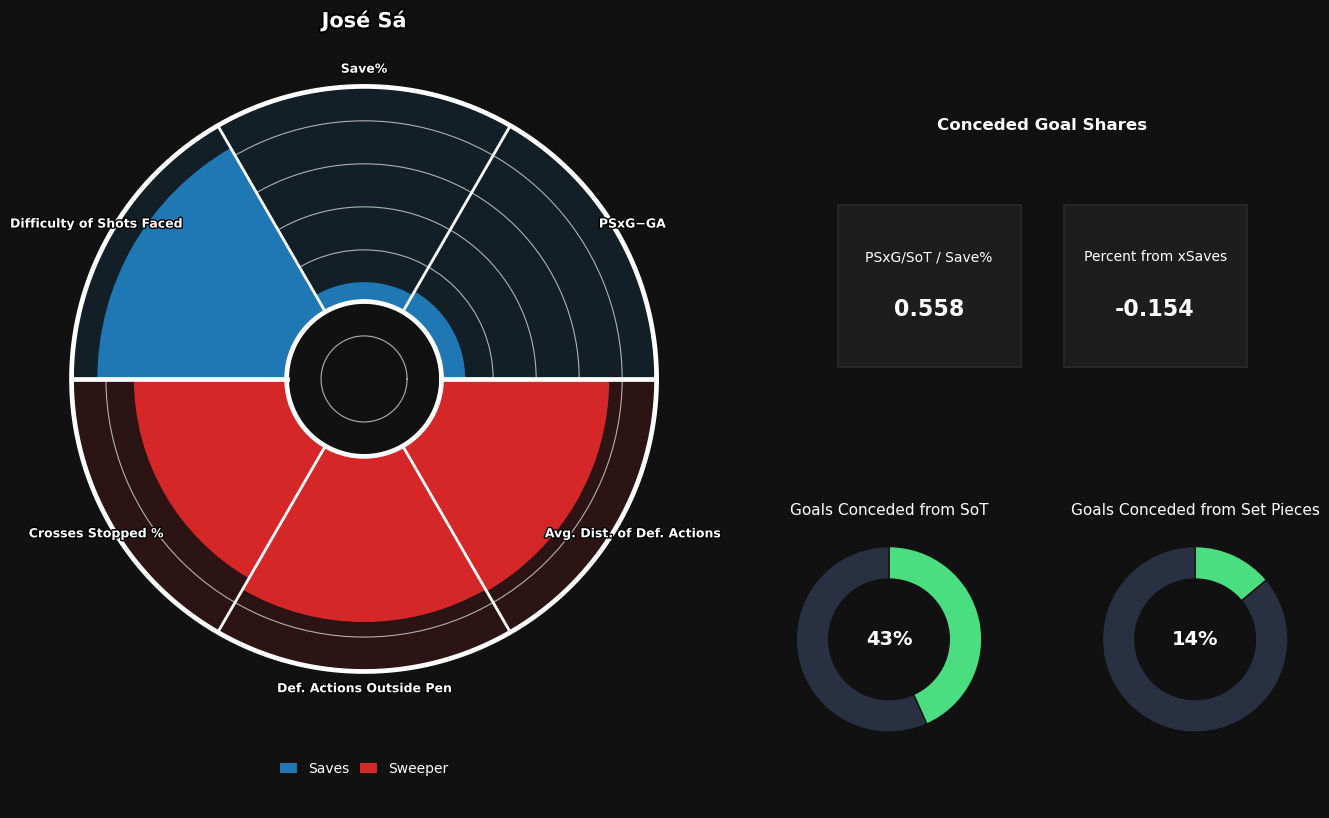

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.7/donuts_dark_gk/gk_donut_Sam_Johnstone.png


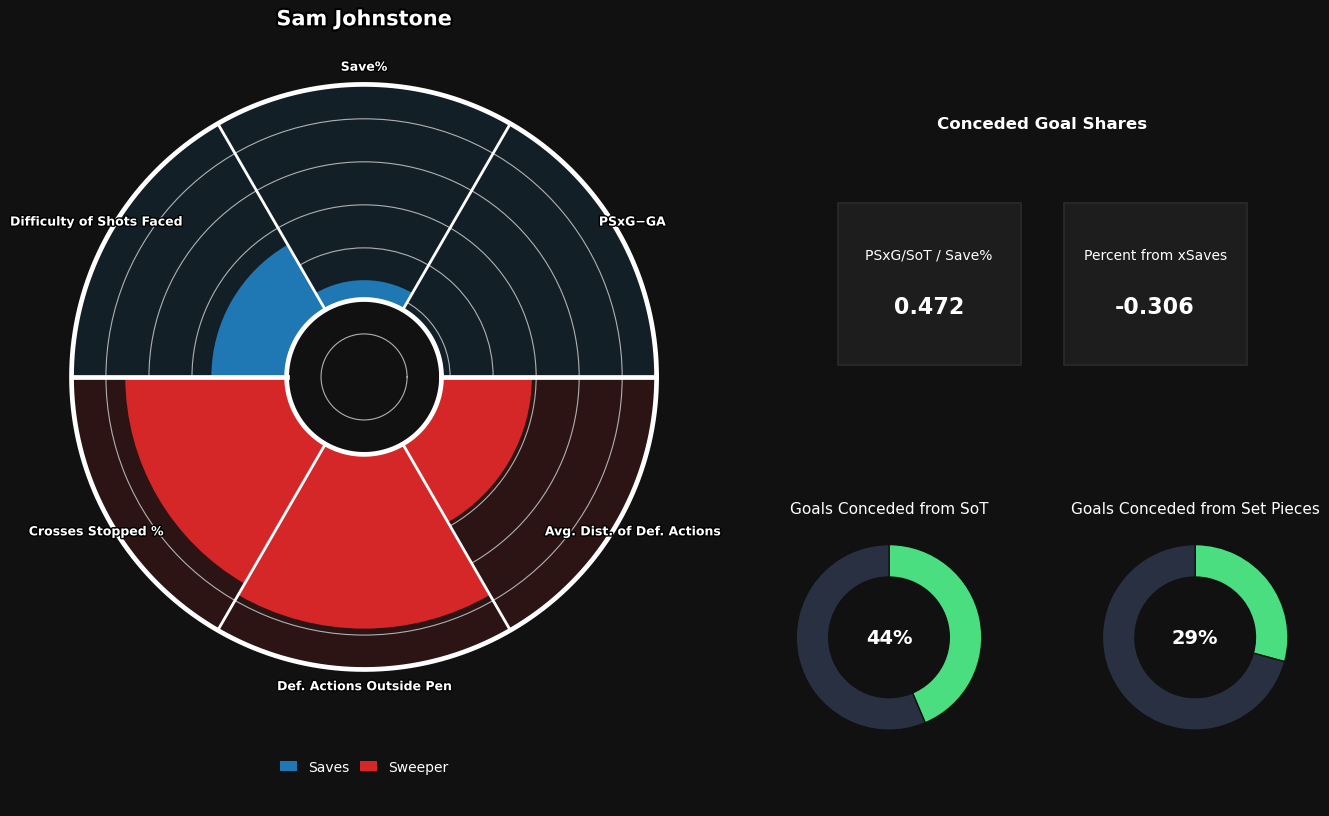

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.7/donuts_dark_gk/gk_donut_Daniel_Bentley.png


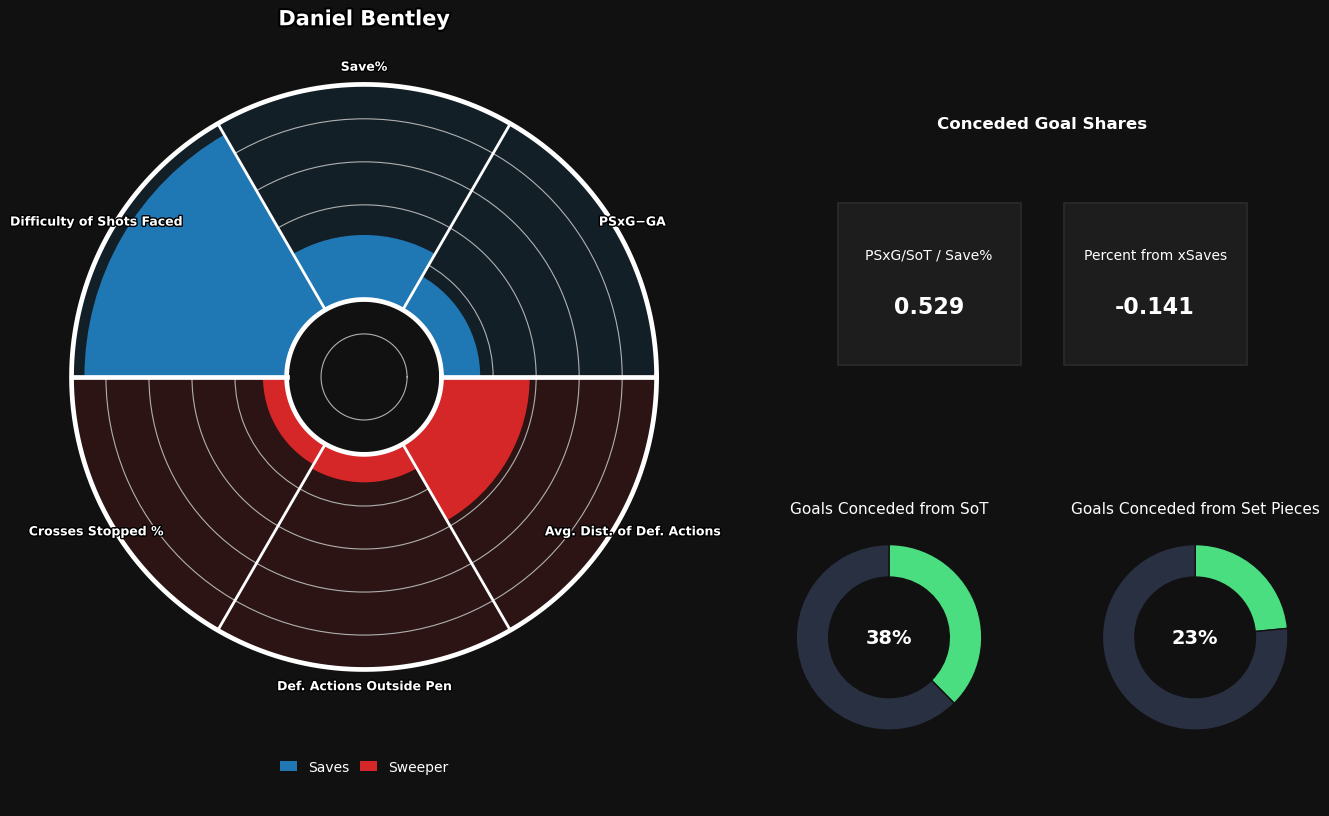

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
from pathlib import Path
import re

FILE = "project2-7.xlsx"         
SHEET = "Sheet1"                 
OUTPUT_DIR = Path("donuts_dark_gk")
SHOW_FIGS = True
PRINT_SAVES = True
TITLE_PREFIX = ""

FIG_BG = AX_BG = "#111111"
SAVES_COLOR   = "#1f77b4"      
SWEEPER_COLOR = "#d62728"      
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.4

TILE_BG = "#1d1d1d"
TILE_EDGE = "#2b2b2b"
TILE_TEXT = "white"
TILE_VALUE = "white"

TITLE_FONTSIZE = 15
LABEL_FONTSIZE = 9
TILE_LABEL_FONTSIZE = 10
TILE_VALUE_FONTSIZE = 16

FIGSIZE = (13.8, 8.2)
INNER_RADIUS   = 0.36
ANNULUS_HEIGHT = 1.0

df = pd.read_excel(FILE, sheet_name=SHEET)

saves_metrics   = ["PSxG-GA", "Save%", "PSxG/SoT"]
sweeper_metrics = ["Crosses Stopped %", "DAOPA", "ADDA"]
metrics_order = saves_metrics + sweeper_metrics

display_names = {
    "PSxG-GA":            "PSxG−GA",
    "Save%":              "Save%",
    "PSxG/SoT":           "Difficulty of Shots Faced",
    "Crosses Stopped %":  "Crosses Stopped %",
    "DAOPA":              "Def. Actions Outside Pen",
    "ADDA":               "Avg. Dist. of Def. Actions"
}

tile_columns = {
    "tile1": {
        "label": "PSxG/SoT / Save%",
        "candidates": [
            r"\(psxg/sot\)/save%", r"psxg/sotoversave%", r"psxg_sot_save%", r"psxgpersotoversave",
            r"psxg/sot/save%", r"psxg_sot\/save%"
        ]
    },
    "tile2": {
        "label": "Percent from xSaves",
        "candidates": [
            r"1-\(ga/psxg\)",            
            r"\(1-\(ga/psxg\)\)",         
            r"1-ga/psxg",           
            r"one_minus_ga_over_psxg",
            r"1minus\(ga/psxg\)", r"\(1minus\(ga/psxg\)\)"
        ]
    }
}

import re
def normalize_name(name: str) -> str:
    """Lowercase, strip spaces/underscores, unify minus and percent symbols."""
    s = str(name).lower()
    s = s.replace("−", "-").replace("–", "-") 
    s = s.replace("%", "percent")
    s = re.sub(r"\s+|_", "", s)               
    return s

def find_column(df_cols, candidates_regex):
    """
    Return actual df column name that matches any regex in candidates after normalization.
    Tries fullmatch first, then 'contains' as a fallback.
    """
    norm_map = {col: normalize_name(col) for col in df_cols}
    # fullmatch pass
    for col, norm in norm_map.items():
        for pat in candidates_regex:
            if re.fullmatch(pat, norm):
                return col
    # fallback: substring contains
    for col, norm in norm_map.items():
        for pat in candidates_regex:
            try:
                if re.search(pat, norm):
                    return col
            except re.error:
                continue
    return None

donut_columns = {
    "donut1": {
        "label": "Goals Conceded from SoT",
        "candidates": [r"ga/sota", r"ga over sota", r"ga_over_sota"]
    },
    "donut2": {
        "label": "Goals Conceded from Set Pieces",
        "candidates": [r"\(fkga\+ckga\)/ga", r"fkga\+ckga over ga", r"deadball_share"]
    }
}

def clamp_0_100(x):
    """Float; NaN→0; clamp [0,100]."""
    try:
        v = float(x)
    except Exception:
        return 0.0
    if np.isnan(v):
        return 0.0
    return float(np.clip(v, 0.0, 100.0))

def metric_color(m):
    return SAVES_COLOR if m in saves_metrics else SWEEPER_COLOR

def nice_number(val, dec=3):
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return "—"
    try:
        if abs(val - round(val)) < 1e-10 and abs(val) < 1e6:
            return f"{int(round(val))}"
        return f"{val:.{dec}f}"
    except Exception:
        return str(val)

def green_donut(ax, share, title, label_inside=True):
    s = 0.0 if share is None or (isinstance(share, float) and np.isnan(share)) else float(np.clip(share, 0, 1))
    ax.set_facecolor(AX_BG)
    ax.pie(
        [s, 1 - s],
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35, edgecolor=FIG_BG),
        colors=["#4ade80", "#293042"],
    )
    if label_inside:
        ax.text(0, 0, f"{s*100:.0f}%", ha="center", va="center",
                color="white", fontsize=14, fontweight="bold")
    ax.set_title(title, color="white", fontsize=11, pad=6)

def normalize_name(name: str) -> str:
    """Lowercase, remove spaces/underscores and collapse punctuation for robust matching."""
    s = str(name).lower()
    s = re.sub(r"\s+", "", s)
    s = s.replace("_", "")
    return s

def find_column(df_cols, candidates_regex):
    """Return actual df column name that matches any regex in candidates (after normalization)."""
    norm_map = {col: normalize_name(col) for col in df_cols}
    for col, norm in norm_map.items():
        for pat in candidates_regex:
            if re.fullmatch(pat, norm):
                return col
    return None

required_cols = metrics_order.copy()

resolved_tiles = {}
for key, spec in tile_columns.items():
    col = find_column(df.columns, spec["candidates"])
    resolved_tiles[key] = {"label": spec["label"], "col": col}
    required_cols.append(col if col else f"[MISSING {spec['label']}]")

resolved_donuts = {}
for key, spec in donut_columns.items():
    col = find_column(df.columns, spec["candidates"])
    resolved_donuts[key] = {"label": spec["label"], "col": col}
    required_cols.append(col if col else f"[MISSING {spec['label']}]")

for col in metrics_order:
    if col not in df.columns:
        print(f"WARNING: Column '{col}' not found. It will be treated as NaN/0.")
for key, info in resolved_tiles.items():
    if info["col"] is None:
        print(f"WARNING: Precomputed tile column for '{info['label']}' not found.")
for key, info in resolved_donuts.items():
    if info["col"] is None:
        print(f"WARNING: Precomputed donut column for '{info['label']}' not found.")

n_metrics = len(metrics_order)
angles = np.linspace(0, 2*np.pi, n_metrics, endpoint=False)
width  = 2*np.pi / n_metrics
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_saves_end = len(saves_metrics)

players = [str(p).strip() for p in df["Player"].astype(str).unique()]
OUTPUT_DIR.mkdir(exist_ok=True)

for name in players:
    row = df.loc[df["Player"].astype(str) == name]
    if row.empty:
        continue
    row = row.iloc[0]

    vals_pct_0_1 = np.array([clamp_0_100(row.get(m, np.nan))/100.0 for m in metrics_order], dtype=float)

    tile1_val = pd.to_numeric(row.get(resolved_tiles["tile1"]["col"], np.nan), errors="coerce") \
                if resolved_tiles["tile1"]["col"] else np.nan
    tile2_val = pd.to_numeric(row.get(resolved_tiles["tile2"]["col"], np.nan), errors="coerce") \
                if resolved_tiles["tile2"]["col"] else np.nan

    def read_share(colname):
        if not colname:
            return np.nan
        v = pd.to_numeric(row.get(colname, np.nan), errors="coerce")
        if pd.isna(v):
            return np.nan
        v = float(v)
        if v > 1.0:
            v = v / 100.0
        return float(np.clip(v, 0.0, 1.0))

    donut1 = read_share(resolved_donuts["donut1"]["col"])  
    donut2 = read_share(resolved_donuts["donut2"]["col"])  

    fig = plt.figure(figsize=FIGSIZE)
    fig.patch.set_facecolor(FIG_BG)

    outer = fig.add_gridspec(
        nrows=1, ncols=2,
        width_ratios=[1.25, 1.00],
        wspace=0.12
    )

    left = outer[0, 0].subgridspec(
        nrows=3, ncols=1,
        height_ratios=[9.0, 0.9, 1.2],   
        hspace=0.0
    )
    ax_polar  = fig.add_subplot(left[0], projection="polar")
    ax_sp0    = fig.add_subplot(left[1])
    ax_legend = fig.add_subplot(left[2])

    right = outer[0, 1].subgridspec(
        nrows=4, ncols=1,
        height_ratios=[1.2, 3.2, 0.4, 5.2],  
        hspace=0.15
    )
    ax_donut_title = fig.add_subplot(right[0])
    ax_tiles       = fig.add_subplot(right[1])  
    ax_sp1         = fig.add_subplot(right[2])
    gs_donuts      = right[3].subgridspec(1, 2, wspace=0.32)

    for sp in (ax_sp0, ax_sp1):
        sp.axis("off"); sp.set_facecolor(FIG_BG)


    ax = ax_polar
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, INNER_RADIUS + ANNULUS_HEIGHT)
    inner_overlay = INNER_RADIUS
    outer_radius  = INNER_RADIUS + ANNULUS_HEIGHT

    ax.bar(
        angles, np.full(n_metrics, ANNULUS_HEIGHT),
        width=width, bottom=inner_overlay, align='edge',
        color=[metric_color(m) for m in metrics_order],
        alpha=0.14, zorder=1, edgecolor=None
    )

    ax.bar(
        angles, vals_pct_0_1 * ANNULUS_HEIGHT,
        width=width, bottom=inner_overlay, align='edge',
        color=[metric_color(m) for m in metrics_order],
        zorder=2, edgecolor=None
    )

    for ang in angles:
        ax.plot([ang, ang], [inner_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)
    for b_idx in [0, idx_saves_end]:
        ax.plot([angles[b_idx], angles[b_idx]],
                [inner_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)

    theta_circle = np.linspace(0, 2*np.pi, 720)
    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)
    ax.plot(theta_circle, np.full_like(theta_circle, inner_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=6, clip_on=False)

    centers = angles + width/2
    for ang, m in zip(centers, metrics_order):
        lbl = display_names.get(m, m)
        txt = ax.text(
            ang, INNER_RADIUS + ANNULUS_HEIGHT + 0.08, lbl,
            ha='center', va='center', fontsize=LABEL_FONTSIZE,
            fontweight='bold', color='white', zorder=7
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])

    # title
    title_text = ax.set_title(
        f"{TITLE_PREFIX}{name}",
        va='bottom', y=1.08,
        fontsize=TITLE_FONTSIZE, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

    ax.set_xticks([]); ax.set_yticklabels([]); ax.set_thetagrids([])

    ax_legend.set_facecolor(FIG_BG)
    ax_legend.axis("off")
    legend_handles = [
        Patch(facecolor=SAVES_COLOR,   label="Saves"),
        Patch(facecolor=SWEEPER_COLOR, label="Sweeper"),
    ]
    leg = ax_legend.legend(
        handles=legend_handles,
        loc='center', ncol=2, frameon=True,
        borderpad=0.6, handlelength=1.2, columnspacing=0.8, labelspacing=0.6
    )
    plt.setp(leg.get_texts(), color='white')
    leg.get_frame().set_facecolor(FIG_BG)
    leg.get_frame().set_edgecolor("none")

    ax_tiles.set_facecolor(FIG_BG)
    ax_tiles.axis("off")
    pad_x = 0.12
    gap   = 0.08
    tile_w = (1.0 - 2*pad_x - gap) / 2.0
    tile_h = 0.78
    y0 = 0.14
    x_positions = [pad_x + i*(tile_w + gap) for i in range(2)]

    tile_vals = [tile1_val, tile2_val]
    tile_labels = [tile_columns["tile1"]["label"], tile_columns["tile2"]["label"]]

    for i in range(2):
        x0 = x_positions[i]
        rect = plt.Rectangle(
            (x0, y0), tile_w, tile_h,
            transform=ax_tiles.transAxes, facecolor=TILE_BG,
            edgecolor=TILE_EDGE, linewidth=1.2
        )
        ax_tiles.add_patch(rect)
        ax_tiles.text(
            x0 + tile_w/2, y0 + tile_h*0.68,
            tile_labels[i],
            ha='center', va='center',
            fontsize=TILE_LABEL_FONTSIZE, color=TILE_TEXT
        )
        ax_tiles.text(
            x0 + tile_w/2, y0 + tile_h*0.36,
            nice_number(tile_vals[i], dec=3),
            ha='center', va='center',
            fontsize=TILE_VALUE_FONTSIZE, color=TILE_VALUE, fontweight='bold'
        )

    ax_donut_title.set_facecolor(FIG_BG)
    ax_donut_title.axis("off")
    ax_donut_title.text(
        0.5, 0.5,
        "Conceded Goal Shares",
        ha='center', va='center', color='white', fontsize=12, fontweight='bold'
    )

    donut_axes = [fig.add_subplot(gs_donuts[0, i]) for i in range(2)]
    for axd in donut_axes:
        axd.set_facecolor(FIG_BG)

    green_donut(donut_axes[0], donut1, donut_columns["donut1"]["label"], label_inside=True)
    green_donut(donut_axes[1], donut2, donut_columns["donut2"]["label"], label_inside=True)

    plt.subplots_adjust(left=0.05, right=0.98, top=0.94, bottom=0.06)
    safe = name.replace("/", "_").replace("\\", "_").replace(" ", "_")
    out_path = OUTPUT_DIR / f"gk_donut_{safe}.png"
    plt.savefig(out_path, dpi=220, facecolor=FIG_BG, bbox_inches="tight", pad_inches=0.28)
    if PRINT_SAVES:
        print(f"Saved: {out_path.resolve()}")
    if SHOW_FIGS:
        plt.show()
    else:
        plt.close(fig)


Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.7/donuts_dark_gk/gk_donut_scatter_group_means.png


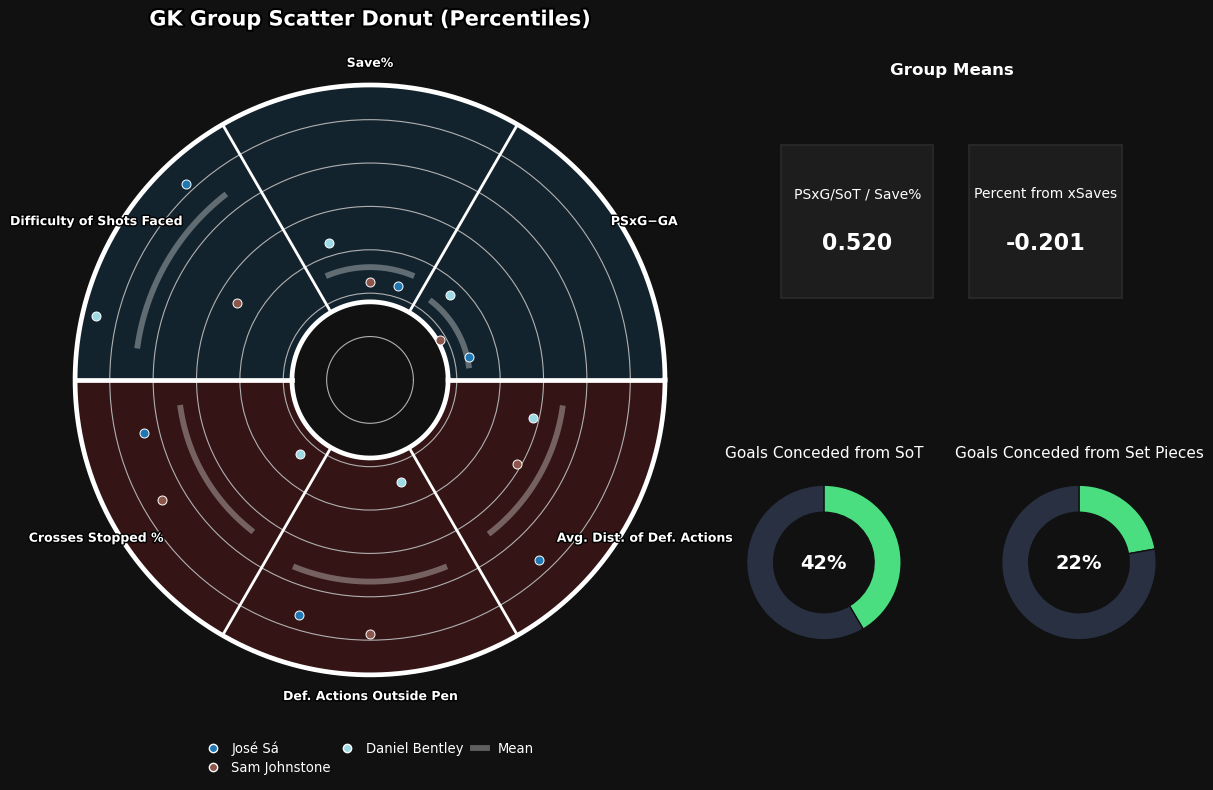

In [ ]:
import matplotlib as mpl
from matplotlib.lines import Line2D

saves_metrics   = ["PSxG-GA", "Save%", "PSxG/SoT"]
sweeper_metrics = ["Crosses Stopped %", "DAOPA", "ADDA"]
metrics_order   = saves_metrics + sweeper_metrics  # 6 total

players_all = [str(p).strip() for p in df["Player"].astype(str).unique()]
vals_mat = []
valid_players = []
for p in players_all:
    row = df.loc[df["Player"].astype(str) == p]
    if row.empty:
        continue
    row = row.iloc[0]
    row_vals = []
    for m in metrics_order:
        v = pd.to_numeric(row.get(m, np.nan), errors='coerce')
        if pd.isna(v):
            vv = np.nan
        else:
            vv = float(np.clip(v, 0.0, 100.0)) / 100.0
        row_vals.append(vv)
    if np.all(np.isnan(row_vals)):
        continue
    vals_mat.append(row_vals)
    valid_players.append(p)

if len(valid_players) == 0:
    print("No players with data to build GK group scatter donut.")
else:
    group_vals = np.array(vals_mat, dtype=float)
    means = np.nanmean(group_vals, axis=0)

    n_metrics = len(metrics_order)  
    angles = np.linspace(0, 2*np.pi, n_metrics, endpoint=False)
    width  = 2*np.pi / n_metrics
    theta_circle  = np.linspace(0, 2*np.pi, 900)
    centers = angles + width/2
    inner_overlay = INNER_RADIUS
    outer_radius  = INNER_RADIUS + ANNULUS_HEIGHT

tile1_col = resolved_tiles["tile1"]["col"] if "resolved_tiles" in globals() else None
tile2_col = resolved_tiles["tile2"]["col"] if "resolved_tiles" in globals() else None
donut1_col = resolved_donuts["donut1"]["col"] if "resolved_donuts" in globals() else None
donut2_col = resolved_donuts["donut2"]["col"] if "resolved_donuts" in globals() else None

if (tile1_col is None or tile1_col not in df.columns) and "find_column" in globals() and "tile_columns" in globals():
    tile1_col = find_column(df.columns, tile_columns["tile1"]["candidates"])
if (tile2_col is None or tile2_col not in df.columns) and "find_column" in globals() and "tile_columns" in globals():
    tile2_col = find_column(df.columns, tile_columns["tile2"]["candidates"])
if (donut1_col is None or donut1_col not in df.columns) and "find_column" in globals() and "donut_columns" in globals():
    donut1_col = find_column(df.columns, donut_columns["donut1"]["candidates"])
if (donut2_col is None or donut2_col not in df.columns) and "find_column" in globals() and "donut_columns" in globals():
    donut2_col = find_column(df.columns, donut_columns["donut2"]["candidates"])

# Label fallbacks (in case dicts aren’t in scope)
tile1_label = tile_columns["tile1"]["label"] if "tile_columns" in globals() else "(PSxG/SoT) / Save%"
tile2_label = tile_columns["tile2"]["label"] if "tile_columns" in globals() else "1 − (GA / PSxG)"
donut1_label = donut_columns["donut1"]["label"] if "donut_columns" in globals() else "GA / SOTA"
donut2_label = donut_columns["donut2"]["label"] if "donut_columns" in globals() else "(FKGA+CKGA) / GA"

def series_mean(col):
    if col and col in df.columns:
        s = pd.to_numeric(df[col], errors="coerce")
        return float(np.nanmean(s)) if s.notna().any() else np.nan
    return np.nan

def share_mean(col):
    if col and col in df.columns:
        s = pd.to_numeric(df[col], errors="coerce").astype(float)
        arr = s.to_numpy()
        arr[~np.isfinite(arr)] = np.nan
        arr = np.where(arr > 1.0, arr / 100.0, arr)
        return float(np.nanmean(arr)) if np.isfinite(arr).any() else np.nan
    return np.nan

tile1_mean = series_mean(tile1_col)
tile2_mean = series_mean(tile2_col)
donut1_mean = share_mean(donut1_col)
donut2_mean = share_mean(donut2_col)

FIGSIZE_GROUP = (14.2, 9.0)  
fig = plt.figure(figsize=FIGSIZE_GROUP)
fig.patch.set_facecolor(FIG_BG)

outer = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.25, 0.95], wspace=0.12)

left = outer[0, 0].subgridspec(nrows=1, ncols=1)
axg = fig.add_subplot(left[0], projection="polar")
axg.set_facecolor(AX_BG)
axg.set_ylim(0, outer_radius)

axg.bar(
    angles, np.full(n_metrics, ANNULUS_HEIGHT),
    width=width, bottom=inner_overlay, align='edge',
    color=[metric_color(m) for m in metrics_order],
    alpha=0.18, zorder=1, edgecolor=None
)
for ang in angles:
    axg.plot([ang, ang], [inner_overlay, outer_radius],
             linewidth=SEP_THIN, color=SEPARATOR_COLOR, alpha=1.0, zorder=3)
idx_saves_end = len(saves_metrics) 
for b_idx in [0, idx_saves_end]:
    axg.plot([angles[b_idx], angles[b_idx]],
             [inner_overlay, outer_radius],
             linewidth=SEP_THICK, color=SEPARATOR_COLOR, alpha=1.0, zorder=4)
axg.plot(theta_circle, np.full_like(theta_circle, outer_radius),
         color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)
axg.plot(theta_circle, np.full_like(theta_circle, inner_overlay),
         color=SEPARATOR_COLOR, linewidth=SEP_THICK, alpha=1.0, zorder=5, clip_on=False)

mean_half = width * 0.36
for i, mu in enumerate(means):
    mu = 0.0 if np.isnan(mu) else float(mu)
    r_mu = inner_overlay + mu * ANNULUS_HEIGHT
    thetas = np.linspace(centers[i] - mean_half, centers[i] + mean_half, 80)
    axg.plot(thetas, np.full_like(thetas, r_mu),
             color="white", linewidth=4.2, alpha=0.33, zorder=6, clip_on=False)

try:
    cmap = mpl.colormaps.get_cmap('tab20').resampled(max(1, len(valid_players)))
except Exception:
    cmap = plt.cm.get_cmap('tab20', max(1, len(valid_players)))
player_colors = {p: cmap(i) for i, p in enumerate(valid_players)}

nP = len(valid_players)
ang_offsets = np.linspace(-width*0.28, width*0.28, nP) if nP > 1 else np.array([0.0])

DOT_SIZE = 42
eps = 0.006
for j, p in enumerate(valid_players):
    vals = group_vals[j]
    thetas = centers + ang_offsets[j]
    rs = inner_overlay + np.nan_to_num(vals, nan=0.0) * ANNULUS_HEIGHT
    rs = np.clip(rs, inner_overlay + eps, outer_radius - eps)
    axg.scatter(thetas, rs, s=DOT_SIZE, color=player_colors[p],
                edgecolor="white", linewidth=0.7, zorder=7.5, label=p, clip_on=False)

for ang, m in zip(centers, metrics_order):
    lab = display_names.get(m, m)
    txt = axg.text(
        ang, INNER_RADIUS + ANNULUS_HEIGHT + 0.10, lab,
        ha='center', va='center', fontsize=LABEL_FONTSIZE,
        fontweight='bold', color='white', zorder=8
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

# title + legend
title_text = axg.set_title(
    "GK Group Scatter Donut (Percentiles)",
    va='bottom', y=1.08,
    fontsize=TITLE_FONTSIZE, fontweight='bold', color='white'
)
title_text.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='black'),
    path_effects.Normal()
])

ncols = min(6, max(3, int(np.ceil(nP / 3))))
handles = [
    Line2D([0], [0], marker='o', linestyle='', markersize=6,
           markerfacecolor=player_colors[p], markeredgecolor='white', label=p)
    for p in valid_players
]
mean_handle = Line2D([0], [0], color="white", lw=4.2, alpha=0.33, label="Mean")
handles.append(mean_handle)
labels = valid_players + ["Mean"]

leg = axg.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.19), 
    ncol=ncols,
    frameon=True,
    handlelength=1.0,
    columnspacing=0.7,         
    labelspacing=0.35,            
    borderaxespad=0.5
)
plt.setp(leg.get_texts(), color='white', fontsize=9.5)
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")
axg.set_xticks([]); axg.set_yticklabels([]); axg.set_thetagrids([])

right = outer[0, 1].subgridspec(nrows=4, ncols=1, height_ratios=[1.1, 3.0, 0.4, 5.0], hspace=0.15)
ax_right_title = fig.add_subplot(right[0]); ax_right_title.axis("off"); ax_right_title.set_facecolor(FIG_BG)
ax_right_title.text(0.5, 0.5, "Group Means", ha='center', va='center',
                    color='white', fontsize=12, fontweight='bold')

ax_right_tiles = fig.add_subplot(right[1]); ax_right_tiles.axis("off"); ax_right_tiles.set_facecolor(FIG_BG)
pad_x = 0.12; gap = 0.08
tile_w = (1.0 - 2*pad_x - gap) / 2.0
tile_h = 0.78; y0 = 0.14
x_positions = [pad_x + i*(tile_w + gap) for i in range(2)]
tile_vals_mean = [tile1_mean, tile2_mean]
tile_labels_mean = [tile1_label, tile2_label]

for i in range(2):
    x0 = x_positions[i]
    rect = plt.Rectangle(
        (x0, y0), tile_w, tile_h,
        transform=ax_right_tiles.transAxes, facecolor=TILE_BG,
        edgecolor=TILE_EDGE, linewidth=1.2
    )
    ax_right_tiles.add_patch(rect)
    ax_right_tiles.text(
        x0 + tile_w/2, y0 + tile_h*0.68,
        tile_labels_mean[i],
        ha='center', va='center',
        fontsize=TILE_LABEL_FONTSIZE, color=TILE_TEXT
    )
    ax_right_tiles.text(
        x0 + tile_w/2, y0 + tile_h*0.36,
        nice_number(tile_vals_mean[i], dec=3),
        ha='center', va='center',
        fontsize=TILE_VALUE_FONTSIZE, color=TILE_VALUE, fontweight='bold'
    )

ax_right_sp = fig.add_subplot(right[2]); ax_right_sp.axis("off"); ax_right_sp.set_facecolor(FIG_BG)
gs_right_donuts = right[3].subgridspec(1, 2, wspace=0.32)
donut_axes = [fig.add_subplot(gs_right_donuts[0, i]) for i in range(2)]
for axd in donut_axes: axd.set_facecolor(FIG_BG)

green_donut(donut_axes[0], donut1_mean, donut1_label, label_inside=True)
green_donut(donut_axes[1], donut2_mean, donut2_label, label_inside=True)

out_path_grp = OUTPUT_DIR / "gk_donut_scatter_group_means.png"
plt.savefig(out_path_grp, dpi=230, bbox_inches="tight", facecolor=FIG_BG, pad_inches=0.28)
if PRINT_SAVES:
    print(f"Saved: {out_path_grp.resolve()}")
if SHOW_FIGS:
    plt.show()
else:
    plt.close(fig)
